In [17]:
import os
from google.colab import drive


drive.mount('/content/drive')
if os.getcwd() != '/content/drive/MyDrive/Advanced_NLP/LM':
  os.chdir('/content/drive/MyDrive/Advanced_NLP/LM')
print(os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Advanced_NLP/LM


In [80]:
import os
import re
import string
import random

from functools import partial
from itertools import groupby
from typing import List, Dict, Union

import torch
import numpy as np

from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from matplotlib import pyplot as plt


SEED = 241

def seed_everything(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)

  if torch.cuda.is_available(): 
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [19]:
class PreprocessText(object):
  def __init__(self,
               preprocess_func,
               sent_split_chars,
               postprocess_func = None) -> None:
    
    self.sent_split_chars = sent_split_chars

    if preprocess_func is not None:
      self.preprocess_func = preprocess_func
    else:
      self.preprocess_func = lambda v: v
    
    if postprocess_func is not None:
      self.postprocess_func = postprocess_func
    else:
      self.postprocess_func = lambda v: v

  def transform(self, path: str) -> List:
    all_text = []
    curr_sentence = []
    with open(path, 'r') as f:
      for text in f.readlines():
        text = self.preprocess_func(text)

        if text == '':
          continue
        
        curr_sentence.append(text)

        if text[-1] in self.sent_split_chars:
          sentence = ' '.join(curr_sentence)
          sentence = self.postprocess_func(sentence)
          all_text.append(sentence)
          curr_sentence = []
    return all_text

In [20]:
def process(text: str) -> List[str]:
  text = text.lower()
  text = re.sub('[-",:!\t]', '', text)
  text = re.sub('\n', ' ', text)
  text = text.strip()
  return text

def post_process(text: str, special_chars: str) -> List[str]:
  text = re.sub(f'[{special_chars}]', '', text)
  text = text.split()
  return text

post_process = partial(post_process, special_chars='.;!')

text_preprocess = PreprocessText(preprocess_func=process, 
                                 postprocess_func=post_process,
                                 sent_split_chars='.;!')

In [21]:
class LMDataset(Dataset):

  def __init__(self,
               path: str, 
               preprocess: PreprocessText = None) -> None:

    self.word2id = {'<EOS>': 0, '<pad>': 1, '<UNK>': 2}

    if preprocess is not None:
      self.texts = preprocess.transform(path)
    else:
      self.texts = []
      with opne(path, 'r') as f:
        for line in f.readlines():
          self.texts.append(line.split())

    for text in self.texts:
      for word in text:
        if word not in self.word2id:
          self.word2id[word] = len(self.word2id)
    
    self.id2word = dict([(index, word) 
                         for word, index in self.word2id.items()])
    
  def text_to_ids(self, text: str) -> List[int]:
    return [self.word2id[word] for word in text]

  def __getitem__(self, index) -> Dict[str, torch.Tensor]:
    input_text = self.texts[index]
    output_text = input_text[1:]
    output_text.append('<EOS>')

    text_len = torch.LongTensor([[len(input_text)]])
    input_text_ids = torch.LongTensor([self.text_to_ids(input_text)])
    output_text_ids = torch.LongTensor([self.text_to_ids(output_text)])

    return {
        'input': input_text_ids,
        'output': output_text_ids,
        'length': text_len
    }

  def __len__(self) -> int:
    return len(self.texts)

In [22]:
def collate_fn(items: List[Dict[str, torch.Tensor]], pad_value: int):
  item_keys = items[0].keys()
  items_max_size = {item: 0 for item in item_keys}
  total_collection = {key: [] for key in item_keys}

  for item in items:
    for key in item:
      if items_max_size[key] < item[key].shape[1]:
        items_max_size[key] = item[key].shape[1]
  
  for item in items:
    for key in item_keys:
      pad_size = items_max_size[key] - item[key].shape[1]
      pad_tensor = torch.zeros((1, pad_size), dtype=item[key].dtype)
      pad_tensor.fill_(pad_value)
      item[key] = torch.cat((item[key], pad_tensor), dim=1)
      total_collection[key].append(item[key])

  for key in total_collection:
    total_collection[key] = torch.cat(total_collection[key], dim=0)
  return total_collection

In [43]:
class RNN(nn.Module):

  def __init__(self, config: Dict[str, Union[int, float]]) -> None:
    super().__init__()
    self.config = config
    self.embedding = nn.Embedding(config['vocab_size'],
                                  config['emb_size'],
                                  padding_idx=config['pad_idx'])

    self.rnn = nn.LSTM(config['emb_size'], 
                       config['hid_size'], 
                       config['n_layers'], 
                       dropout=config['dropout'] 
                               if config['n_layers'] > 1 else 0,
                       batch_first=True)
    
    self.output = nn.Linear(config['hid_size'], config['vocab_size'])

  def init_hidden(self) -> torch.Tensor:
    hidden = torch.zeros((self.config['n_layers'], self.config['bs'], self.config['hid_size']))
    cell = torch.zeros((self.config['n_layers'], self.config['bs'], self.config['hid_size']))
    nn.init.uniform_(hidden, a=-0.3, b=0.3)
    nn.init.uniform_(cell, a=-0.3, b=0.3)
    return hidden, cell

  def forward(self, text, length, hidden) -> torch.Tensor:
    embeded = self.embedding(text)
    pack_text = nn.utils.rnn.pack_padded_sequence(embeded, length, 
                                                  batch_first=True, 
                                                  enforce_sorted=False)
    
    pack_outputs, (hidden, cell) = self.rnn(pack_text, hidden)
    outputs, lens = nn.utils.rnn.pad_packed_sequence(pack_outputs)
    outputs = outputs.permute(1, 0, 2).contiguous()
    predictions = self.output(outputs)
    predictions = predictions.view(-1, predictions.shape[2])
    predictions = F.log_softmax(predictions, dim=1)
    return predictions, (hidden, cell)

In [63]:
from tqdm.notebook import tqdm


class Trainer(object):

  def __init__(self, model, criterion, optimizer) -> None:
    self.model = model
    self.criterion = criterion
    self.optimizer = optimizer
    self.train_losses = []
    self.eval_losses = []

  def fit(self, loader, n_epochs, eval_loader=None) -> nn.Module:
    train_loss = None
    eval_loss = None
    for epoch in tqdm(range(n_epochs)):
      train_loss = 0
      self.model.train()
      for batch in loader:
        loss = self.handle_batch(batch, train=True)
        train_loss += loss
      if eval_loader is not None:
        eval_loss = 0
        with torch.no_grad():
          self.model.eval()
          for batch in eval_loader:
            loss = self.handle_batch(batch, train=False)
            eval_loss += loss
      # print(f'{epoch + 1}: {train_loss}')
      self.train_losses.append(train_loss)
      if eval_loss is not None:
        self.eval_losses.append(eval_loss)
    return self.model

  def handle_batch(self, batch, train=True) -> float:
    inputs = batch['input']
    outputs = batch['output']
    length = batch['length']

    if train:
      optimizer.zero_grad()
      hidden, cell = self.model.init_hidden()

      batch_loss = 0
      total_loss = 0

      for index in range(inputs.shape[1]):
        curr_input = inputs[:, index]
        curr_input = curr_input.unsqueeze(1)
        input_lenght = torch.ones_like(length)
        input_lenght = input_lenght.squeeze()

        predictions, (hidden, cell) = self.model(curr_input, input_lenght, (hidden, cell))
        loss = criterion(predictions, outputs[:, index])

        total_loss += loss

      total_loss.backward()
      optimizer.step()

      batch_loss += total_loss.item()

    else:
      hidden, cell = self.model.init_hidden()
      batch_loss = 0

      for index in range(inputs.shape[1]):
        curr_input = inputs[:, index]
        curr_input = curr_input.unsqueeze(1)
        input_lenght = torch.ones_like(length)
        input_lenght = input_lenght.squeeze()

        predictions, (hidden, cell) = self.model(curr_input, input_lenght, (hidden, cell))
        loss = criterion(predictions, outputs[:, index])
        total_loss += loss

      batch_loss += total_loss.item()
    return batch_loss     

  def plot_loss_curve(self, eval=False) -> None:
    plt.plot(self.train_losses, label='Train')
    if eval:
      plt.plot(self.eval_losses, label='Eval')
    plt.xlabel('N epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.show()


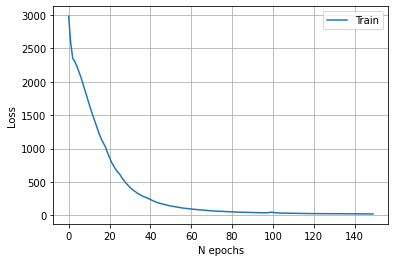

In [64]:
batch_size = 32

dataset = LMDataset('data/LM.txt', text_preprocess)

config = {
    'vocab_size': len(dataset.word2id),
    'bs': batch_size,
    'emb_size': 256,
    'hid_size': 256,
    'n_layers': 2,
    'dropout': 0.35,
    'pad_idx': dataset.word2id['<pad>']
}

collate_fn = partial(collate_fn, pad_value=dataset.word2id['<pad>'])
train_loader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate_fn)

lm_model = RNN(config)
criterion = nn.NLLLoss(ignore_index=config['pad_idx'])
optimizer = torch.optim.Adam(lm_model.parameters(), lr=1e-3)

trainer = Trainer(lm_model, criterion, optimizer)
trainer.fit(train_loader, n_epochs=150)
trainer.plot_loss_curve()

In [1]:
# from tqdm.notebook import tqdm


# for epoch in range(51):
#   lm_model.train()
#   total_loss = 0
#   for batch in train_loader:
#     input = batch['input']
#     output = batch['output']
#     lenght = batch['length']
#     lenght = lenght.squeeze()

#     output = output.view(-1, 1)
#     output = output.squeeze()

#     optimizer.zero_grad()

#     hidden, cell = lm_model.init_hidden()
#     predictions, (hidden, cell) = lm_model(input, lenght, (hidden, cell))

#     loss = criterion(predictions, output)
#     loss.backward()

#     optimizer.step()
#     total_loss += loss.item()

#   if epoch % 10 == 0:
#     print(epoch, total_loss)

In [520]:
np.sum([param.numel() for name, param in lm_model.named_parameters()])

7661869

In [67]:
def choose_from_top(probs, values):
  probs = np.abs(probs)
  probs = np.exp(probs) / np.sum(np.exp(probs))
  value = np.random.choice(values, p=probs)
  return value

In [79]:
input_str = 'три'
new_word = None
count = 0

with torch.no_grad():
  lm_model.eval()
  hidden = lm_model.init_hidden()
  hidden, cell = (torch.zeros((config['n_layers'], 1, config['hid_size'])), \
                  torch.zeros((config['n_layers'], 1, config['hid_size'])))

  while new_word != '<EOS>' and count < 10:
    input_tensor = torch.LongTensor([dataset.text_to_ids(input_str.split())])
    lenght_tensor = torch.LongTensor([len(input_str.split())])
    predictions, (hidden, cell) = lm_model(input_tensor, lenght_tensor, (hidden, cell))
    top_values, top_indexes = torch.topk(predictions, k=1, dim=1)
    top_values = top_values.numpy()[0]
    top_indexes = top_indexes.numpy()[0]
    top_index = choose_from_top(top_values, top_indexes)

    # top_index = torch.argmax(predictions, dim=1).numpy()[0]
    new_word = dataset.id2word[top_index]
    input_str = input_str + ' ' + new_word
    count += 1
  print(' '.join([word for word, _ in groupby(input_str.split())]))

три девицы под пряли окном девицы вечерком
